In [1]:
from yugiquery import *

header("Rush Duel")

<div align='center'>
    <br>
    <!-- Pre Style needed to fix HTML formatting -->
    <pre style="line-height: var(--jp-code-line-height); font-family: var(--jp-code-font-family)">
    ██    ██ ██    ██  ██████  ██  ██████  ██    ██ ███████ ██████  ██    ██ 
     ██  ██  ██    ██ ██       ██ ██    ██ ██    ██ ██      ██   ██  ██  ██  
      ████   ██    ██ ██   ███ ██ ██    ██ ██    ██ █████   ██████    ████   
       ██    ██    ██ ██    ██ ██ ██ ▄▄ ██ ██    ██ ██      ██   ██    ██    
       ██     ██████   ██████  ██  ██████   ██████  ███████ ██   ██    ██    
                                      ▀▀                                     
    </pre>
</div>
<div align='right'>
    Rush Duel - Execution started 26/06/2023 04:06 UTC <br>
    By <b>Guilherme Ruiz</b>
</div>

---

Table of Contents
=================

*   [1  Data aquisition](#Data-aquisition)
    *   [1.1  Fetch online data](#Fetch-online-data)
    *   [1.2  Merge data](#Merge-data)
*   [2  Check changes](#Check-changes)
    *   [2.1  Load previous data](#Load-previous-data)
    *   [2.2  Generate changelog](#Generate-changelog)
    *   [2.3  Save data](#Save-data)
*   [3  Data visualization](#Data-visualization)
    *   [3.1  Card type](#Card-type)
    *   [3.2  Monsters](#Monsters)
        *   [3.2.1  Attribute](#Attribute)
        *   [3.2.2  Primary type](#Primary-type)
            *   [3.2.2.1  Has effect discrimination](#Has-effect-discrimination)
            *   [3.2.2.2  By attribute](#By-attribute)
        *   [3.2.3  Monster type](#Monster-type)
            *   [3.2.3.1  By Attribute](#By-Attribute)
            *   [3.2.3.2  By primary type](#By-primary-type)
        *   [3.2.4  Effect type](#Effect-type)
        *   [3.2.5  ATK](#ATK)
        *   [3.2.6  DEF](#DEF)
        *   [3.2.7  Maximum mode](#Maximum-mode)
            *   [3.2.7.1  MAXIMUM ATK](#MAXIMUM-ATK)
        *   [3.2.8  Level/Rank](#Level/Rank)
            *   [3.2.8.1  ATK statistics](#ATK-statistics)
            *   [3.2.8.2  DEF statistics](#DEF-statistics)
    *   [3.3  Spell & Trap](#Spell-&-Trap)
        *   [3.3.1  Properties](#Properties)
    *   [3.4  Archseries](#Archseries)
        *   [3.4.1  By card type](#By-card-type)
        *   [3.4.2  By primary type](#By-primary-type)
        *   [3.4.3  By monster type](#By-monster-type)
        *   [3.4.4  By property](#By-property)
    *   [3.5  Legend](#Legend)
        *   *   [3.5.0.1  By card type](#By-card-type)
            *   [3.5.0.2  By Attribute](#By-Attribute)
            *   [3.5.0.3  By primary type](#By-primary-type)
            *   [3.5.0.4  By monster type](#By-monster-type)
    *   [3.6  Artworks](#Artworks)
        *   [3.6.1  By card type](#By-card-type)
        *   [3.6.2  By primary type](#By-primary-type)
    *   [3.7  Errata](#Errata)
        *   [3.7.1  By card type](#By-card-type)
        *   [3.7.2  By primary type](#By-primary-type)
        *   [3.7.3  By artwork](#By-artwork)
*   [4  Epilogue](#Epilogue)
    *   [4.1  HTML export](#HTML-export)
<!--     *   [4.2  Git](#Git) -->

# Data aquisition

## Fetch online data

In [2]:
# Timestamp
timestamp = pd.Timestamp.now()

In [3]:
# Fetch rush cards
rush_df = fetch_rush()

# Fetch errata
errata_df = fetch_errata()

1601 results


4859 results


## Merge data

In [4]:
rush_df = merge_errata(rush_df, errata_df)
print("Data merged")

Data merged

# Check changes

## Load previous data

In [5]:
# Get list of files
files_list = sorted(
    glob.glob("../data/all_rush_*.csv"), key=os.path.getctime, reverse=True
)
# Get second newest file if exist
if files_list:
    latest_file = files_list[0]
    # Load csv avoiding converting "NA" to NaN
    previous_df = pd.read_csv(
        latest_file, dtype=object, keep_default_na=False, na_values=[""]
    )
    # Correct tuples
    tuple_cols = [
        "Effect type",
        "Archseries",
        "Artwork",
        "Errata",
        "Legend",
        "Maximum mode",
    ]
    for col in tuple_cols:
        previous_df[col] = previous_df[col].dropna().apply(literal_eval)
    # Force dtypes to match current df
    previous_df = previous_df.astype(
        rush_df[previous_df.columns.intersection(rush_df.columns)].dtypes.to_dict()
    )
    previous_ts = pd.to_datetime(
        os.path.basename(latest_file).split("_")[-1].split(".csv")[0]
    )
    print("File loaded")
else:
    previous_df = None
    print("No older files")

File loaded

## Generate changelog

In [6]:
if previous_df is None:
    changelog = None
    print("Skipped")
else:
    changelog = generate_changelog(previous_df, rush_df, col="Name")
    if not changelog.empty:
        display(changelog)
        changelog.to_csv(
            f'../data/rush_changelog_{previous_ts.isoformat(timespec="minutes")}_{timestamp.isoformat(timespec="minutes")}.csv',
            index=True,
        )
        print("Changelog saved")

,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,Level/Rank,Modification date,Errata,Version
Name,,,,,,,,,,,
Abysslayer Leviaknight,False,DARK,Effect Monster,Sea Serpent,"(Continuous Effect,)",2000,2500,8,2023-06-24 23:39:47,NaN,New
Blazebolt Chemistorm Fenghuang Volcalize Phoenix,False,FIRE,Effect Monster,Pyro,"(Effect,)",0,2400,10,2023-06-03 11:04:58,NaN,Old
Blazebolt Chemistorm Fenghuang Volcalize Phoenix,True,FIRE,Effect Monster,Pyro,"(Effect,)",0,2400,10,2023-06-21 03:22:39,NaN,New
Blazebolt Chemistorm Fenghuang Volcalize Phoenix [L],False,FIRE,Effect Monster,Thunder,"(Effect,)",0,2000,10,2023-06-03 11:08:16,NaN,Old
Blazebolt Chemistorm Fenghuang Volcalize Phoenix [L],True,FIRE,Effect Monster,Thunder,"(Effect,)",0,2000,10,2023-06-21 03:25:26,NaN,New
Blazebolt Chemistorm Fenghuang Volcalize Phoenix [R],False,FIRE,Effect Monster,Aqua,"(Effect,)",0,2000,10,2023-06-03 11:10:40,NaN,Old
Blazebolt Chemistorm Fenghuang Volcalize Phoenix [R],True,FIRE,Effect Monster,Aqua,"(Effect,)",0,2000,10,2023-06-21 03:28:19,NaN,New
Bolt the Conduction Spirit,False,FIRE,Effect Monster,Thunder,"(Effect,)",0,400,2,2023-06-21 18:26:01,NaN,New
Boton the Music Princess,False,WIND,Normal Monster,Warrior,NaN,500,0,1,2023-06-02 20:01:08,NaN,Old


Changelog saved

## Save data

In [7]:
if changelog is not None and changelog.empty:
    print("No changes. New data not saved")
else:
    rush_df.to_csv(
        f'../data/all_rush_{timestamp.isoformat(timespec="minutes")}.csv', index=False
    )
    print("Data saved")

Data saved

# Data visualization

In [8]:
rush_df

,Name,Card type,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
0,1-Up,Trap Card,Normal Trap Card,NaN,False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,1-Up,https://yugipedia.com/wiki/1-Up,NaN,2023-03-17 23:22:24,NaN
1,300 Light-Year Red Cloak,Spell Card,Normal Spell Card,"(Cosmic Urban Legend,)",False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,300 Light-Year Red Cloak,https://yugipedia.com/wiki/300_Light-Year_Red_...,NaN,2023-03-17 23:23:00,NaN
2,7 Chance,Trap Card,Normal Trap Card,NaN,False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,7 Chance,https://yugipedia.com/wiki/7_Chance,NaN,2023-03-17 23:23:31,NaN
3,Abare Ushioni,Monster Card,NaN,NaN,False,False,EARTH,Effect Monster,Beast-Warrior,"(Effect,)",1200,1200,NaN,4,Abare Ushioni (Rush Duel),https://yugipedia.com/wiki/Abare_Ushioni_(Rush...,NaN,2023-03-17 23:32:10,"(Any,)"
4,Abyss Flash,Spell Card,Normal Spell Card,NaN,False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,Abyss Flash,https://yugipedia.com/wiki/Abyss_Flash,NaN,2023-04-08 01:26:02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,Zeptron,Monster Card,NaN,"(Tron (series),)",False,False,LIGHT,Effect Monster,Cyberse,"(Effect,)",100,500,NaN,2,Zeptron,https://yugipedia.com/wiki/Zeptron,NaN,2023-06-20 01:12:36,NaN
1597,Zombie Carnival,Spell Card,Field Spell Card,NaN,False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,Zombie Carnival,https://yugipedia.com/wiki/Zombie_Carnival,NaN,2023-06-04 01:10:45,NaN
1598,Zombie Fireworks,Spell Card,Normal Spell Card,NaN,False,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,Zombie Fireworks,https://yugipedia.com/wiki/Zombie_Fireworks,NaN,2023-03-20 21:17:22,NaN
1599,Zubaba Batter,Monster Card,NaN,"(Baseball,)",False,False,FIRE,Normal Monster,Warrior,NaN,400,1500,NaN,4,Zubaba Batter,https://yugipedia.com/wiki/Zubaba_Batter,NaN,2023-03-20 21:23:45,NaN


## Card type

In [9]:
rush_df["Card type"].nunique()

4

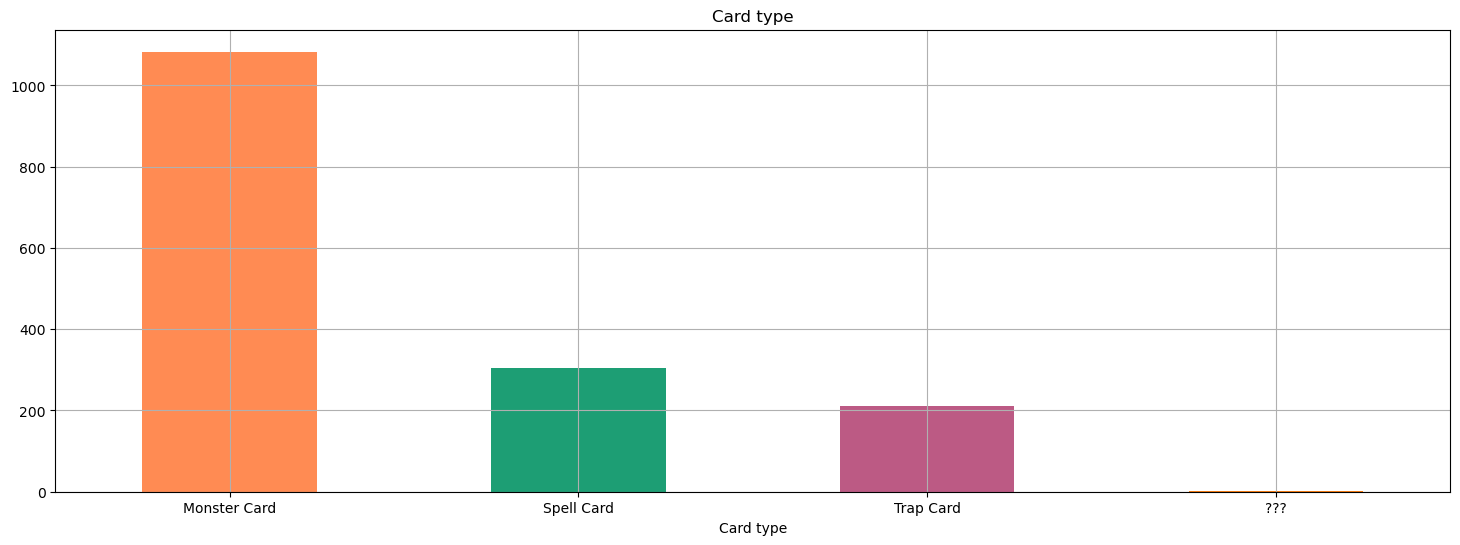

In [10]:
card_type_colors = [colors_dict[i] for i in rush_df["Card type"].value_counts().index]
rush_df["Card type"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=card_type_colors, title="Card type"
)
plt.show()

## Monsters

### Attribute

In [11]:
print("Total number of attributes:", rush_df["Attribute"].nunique())

Total number of attributes:

7

In [12]:
rush_df.drop(columns=["Card type"]).groupby("Attribute").nunique()

,Name,Property,Archseries,Legend,Maximum mode,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Attribute,,,,,,,,,,,,,,,,,
???,4,0,0,1,1,0,0,0,1,1,0,1,4,4,0,4,0
DARK,238,0,28,2,2,3,24,5,30,34,2,12,238,238,3,238,4
EARTH,215,0,20,2,2,3,16,4,29,31,2,11,215,215,2,215,4
FIRE,136,0,17,2,2,3,22,5,25,29,4,10,136,136,2,136,3
LIGHT,297,0,33,2,2,3,24,5,28,34,2,10,297,297,3,297,4
WATER,101,0,12,2,1,3,21,2,24,25,0,9,101,101,2,101,2
WIND,92,0,13,2,2,3,14,2,25,28,1,10,92,92,2,92,3


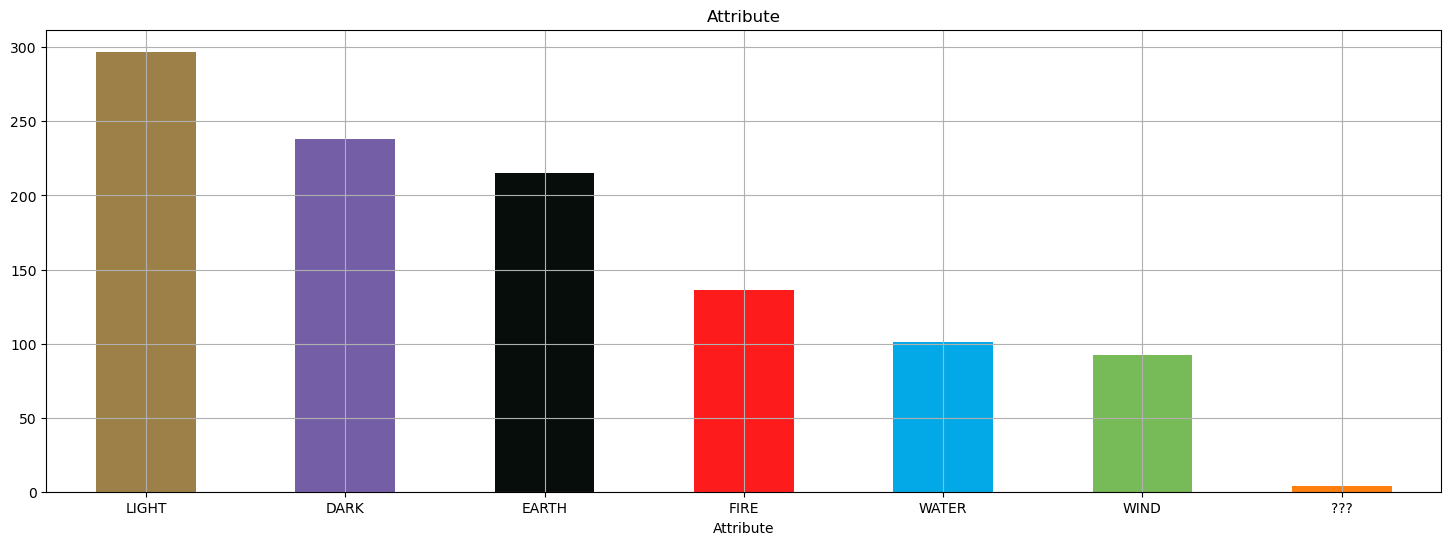

In [13]:
attribute_colors = [colors_dict[i] for i in rush_df["Attribute"].value_counts().index]
rush_df["Attribute"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=attribute_colors, title="Attribute"
)
plt.show()

### Primary type

In [14]:
print("Total number of primary types:", rush_df["Primary type"].nunique())

Total number of primary types:

3

In [15]:
rush_df.drop(columns=["Card type"]).groupby("Primary type").nunique()

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Primary type,,,,,,,,,,,,,,,,,
Effect Monster,643,0,58,2,2,6,24,5,28,29,5,9,643,643,3,643,3
Fusion Monster,101,0,32,1,1,6,20,3,21,21,0,9,101,101,2,101,4
Normal Monster,332,0,46,2,1,6,24,0,28,27,0,8,332,332,2,332,4


#### Has effect discrimination

In [16]:
has_effect = (
    rush_df["Primary type"]
    .where(rush_df["Effect type"].notna())
    .value_counts()
    .rename("Effect")
)
no_effect = (
    rush_df["Primary type"]
    .where(rush_df["Effect type"].isna())
    .value_counts()
    .rename("No Effect")
)
effect = pd.concat([has_effect, no_effect], axis=1).fillna(0).astype(int)
effect

,Effect,No Effect
Primary type,,
Effect Monster,643,0
Fusion Monster,97,4
Normal Monster,0,332


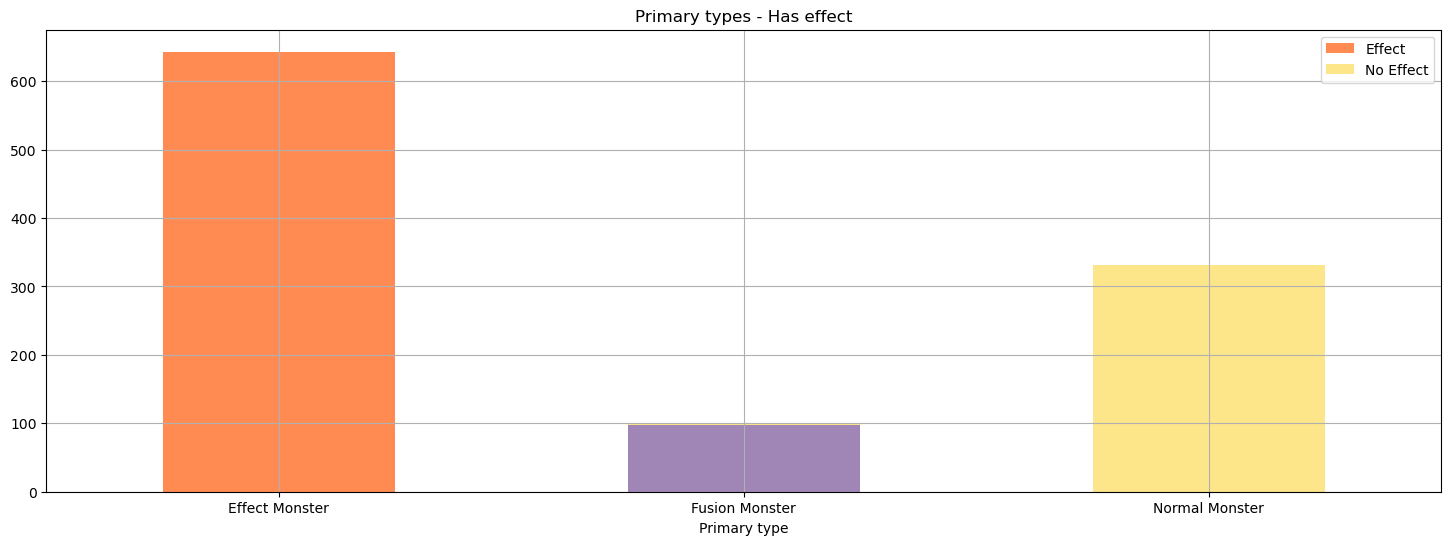

In [17]:
monster_type_colors = {
    "No Effect": colors_dict["Normal Monster"],
    "Effect": [colors_dict[i] for i in effect.index],
}
effect.plot.bar(
    figsize=(18, 6),
    stacked=True,
    grid=True,
    rot=0,
    legend=True,
    color=monster_type_colors,
    title="Primary types - Has effect",
)
# plt.yscale('log')
plt.show()

Obs: Effect monster can show as no effect if it is not released yet

#### By attribute

In [18]:
primmary_crosstab = pd.crosstab(rush_df["Primary type"], rush_df["Attribute"])
primmary_crosstab

Attribute,DARK,EARTH,FIRE,LIGHT,WATER,WIND
Primary type,,,,,,
Effect Monster,157,113,82,182,59,50
Fusion Monster,27,17,13,33,5,6
Normal Monster,53,84,41,82,37,35


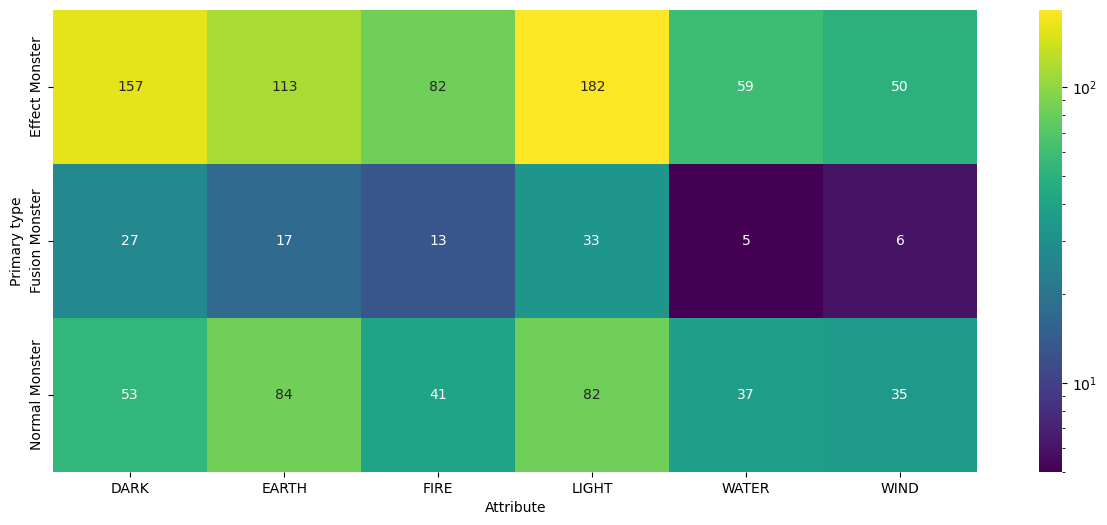

In [19]:
plt.figure(figsize=(16, 6))
sns.heatmap(
    primmary_crosstab,
    annot=True,
    fmt="g",
    cmap="viridis",
    square=True,
    norm=mc.LogNorm(),
)
plt.show()

### Monster type

In [20]:
print("Total number of monster types:", rush_df["Monster type"].nunique())

Total number of monster types:

29

In [21]:
rush_df.drop(columns=["Card type"]).groupby("Monster type").nunique()

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Monster type,,,,,,,,,,,,,,,,,
Aqua,43,0,5,2,2,4,2,1,11,18,0,8,43,43,2,43,1
Beast,50,0,4,2,1,6,3,1,18,25,0,8,50,50,2,50,3
Beast-Warrior,33,0,3,2,1,4,3,2,16,17,0,8,33,33,1,33,2
Celestial Warrior,7,0,3,1,1,2,1,2,5,6,0,1,7,7,0,7,0
Cyberse,26,0,3,1,2,4,3,2,7,19,1,10,26,26,0,26,0
Cyborg,5,0,1,1,1,1,1,1,1,2,0,1,5,5,0,5,0
Dinosaur,21,0,2,1,2,4,3,3,13,16,1,9,21,21,0,21,1
Dragon,99,0,8,2,2,6,3,3,25,31,1,12,99,99,1,99,4
Fairy,36,0,5,2,1,6,2,3,15,14,0,8,36,36,1,36,1


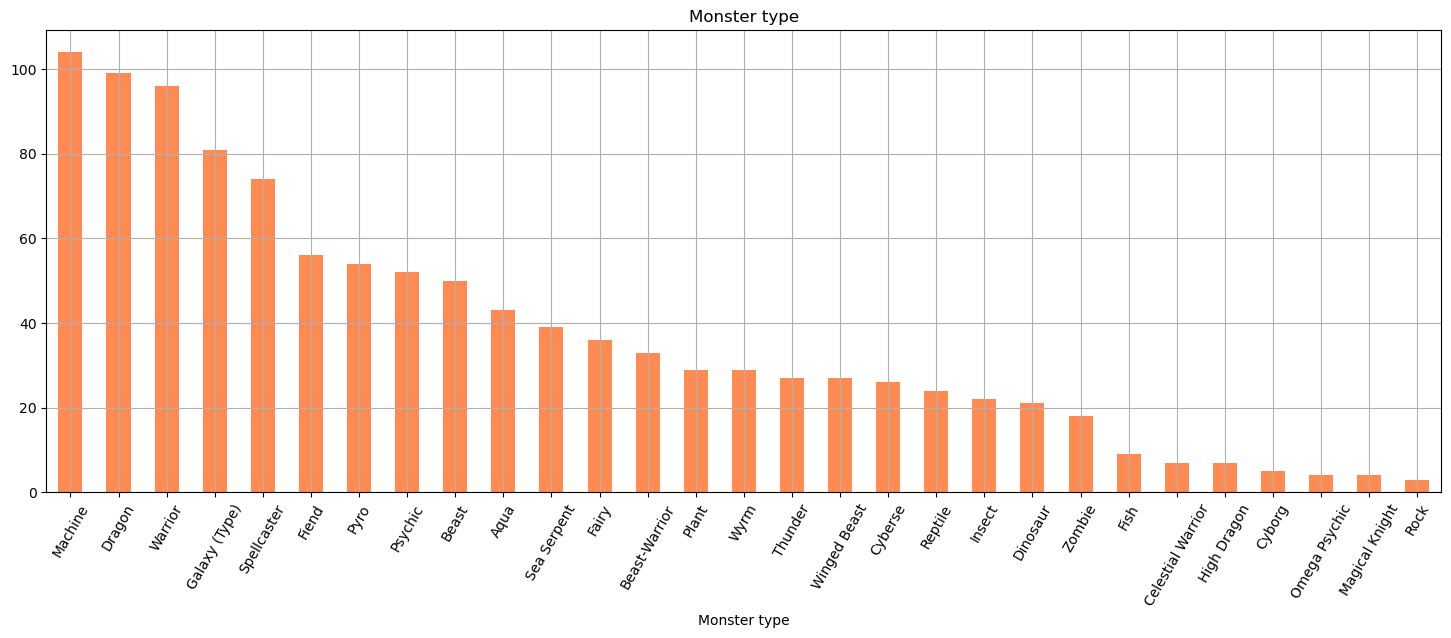

In [22]:
monster_type_colors = colors_dict["Monster Card"]
rush_df["Monster type"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=60, color=monster_type_colors, title="Monster type"
)
plt.show()

#### By Attribute

In [23]:
monster_crosstab = pd.crosstab(
    rush_df["Monster type"], rush_df["Attribute"], dropna=False
)
monster_crosstab

Attribute,???,DARK,EARTH,FIRE,LIGHT,WATER,WIND
Monster type,,,,,,,
Aqua,0,3,0,4,11,25,0
Beast,0,5,21,9,8,2,5
Beast-Warrior,0,13,17,2,0,0,1
Celestial Warrior,0,2,0,0,5,0,0
Cyberse,0,5,0,2,18,1,0
Cyborg,0,0,0,0,5,0,0
Dinosaur,0,1,12,2,6,0,0
Dragon,0,20,15,11,34,4,15
Fairy,0,12,2,2,14,2,4


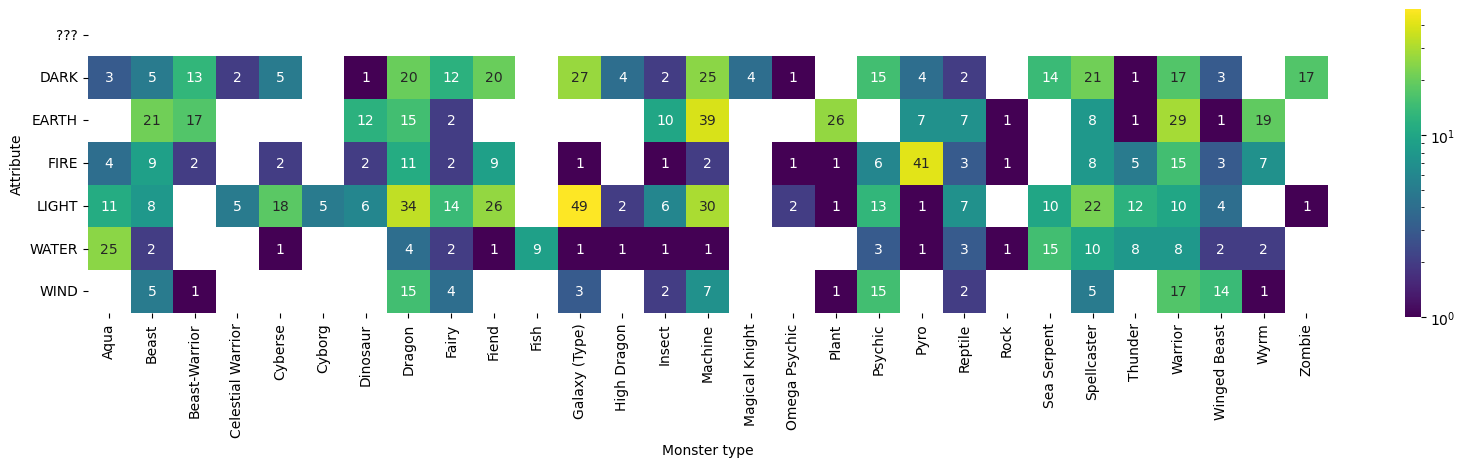

In [24]:
plt.figure(figsize=(20, 4))
sns.heatmap(
    monster_crosstab[monster_crosstab > 0].T,
    annot=True,
    fmt="g",
    cmap="viridis",
    square=True,
    norm=mc.LogNorm(),
)
plt.show()

#### By primary type

In [25]:
monster_crosstab_b = pd.crosstab(
    rush_df["Monster type"], rush_df["Primary type"], dropna=False
)
monster_crosstab_b

Primary type,Effect Monster,Fusion Monster,Normal Monster
Monster type,,,
Aqua,21,0,22
Beast,21,2,27
Beast-Warrior,17,2,14
Celestial Warrior,0,7,0
Cyberse,20,2,4
Cyborg,0,5,0
Dinosaur,11,1,9
Dragon,56,8,33
Fairy,23,0,13


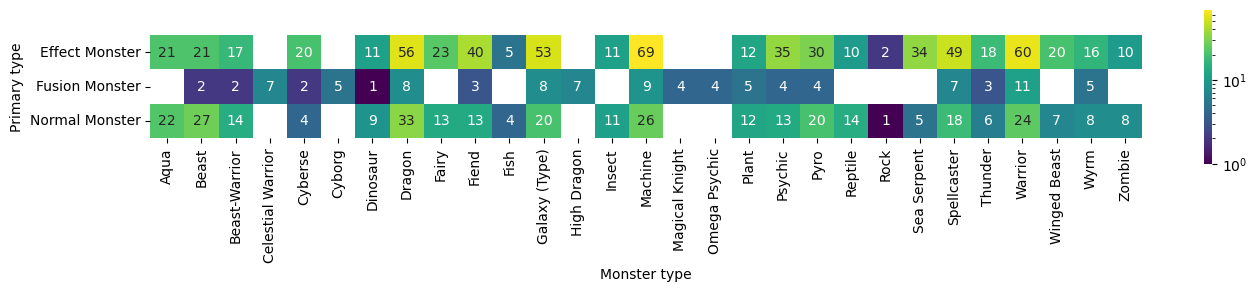

In [26]:
plt.figure(figsize=(16, 2))
sns.heatmap(
    monster_crosstab_b[monster_crosstab_b > 0].T,
    annot=True,
    fmt="g",
    cmap="viridis",
    square=True,
    norm=mc.LogNorm(),
)
plt.show()

### Effect type

In [27]:
print("Total number of effect types:", rush_df["Effect type"].explode().nunique())

Total number of effect types:

4

In [28]:
rush_df[rush_df["Effect type"].notna()].drop(columns=["Card type"]).explode(
    "Effect type"
).groupby("Effect type").nunique()

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Effect type,,,,,,,,,,,,,,,,,
Continuous Effect,57,0,15,2,2,5,2,18,20,24,4,10,57,57,2,57,4
Effect,1174,5,73,2,2,6,2,24,30,34,3,10,1174,1174,3,1174,4
Multi-Choice Effect,25,0,9,1,1,4,1,5,8,8,0,3,25,25,1,25,0
Summoning condition,12,0,6,2,2,4,1,8,3,7,5,4,12,12,0,12,1


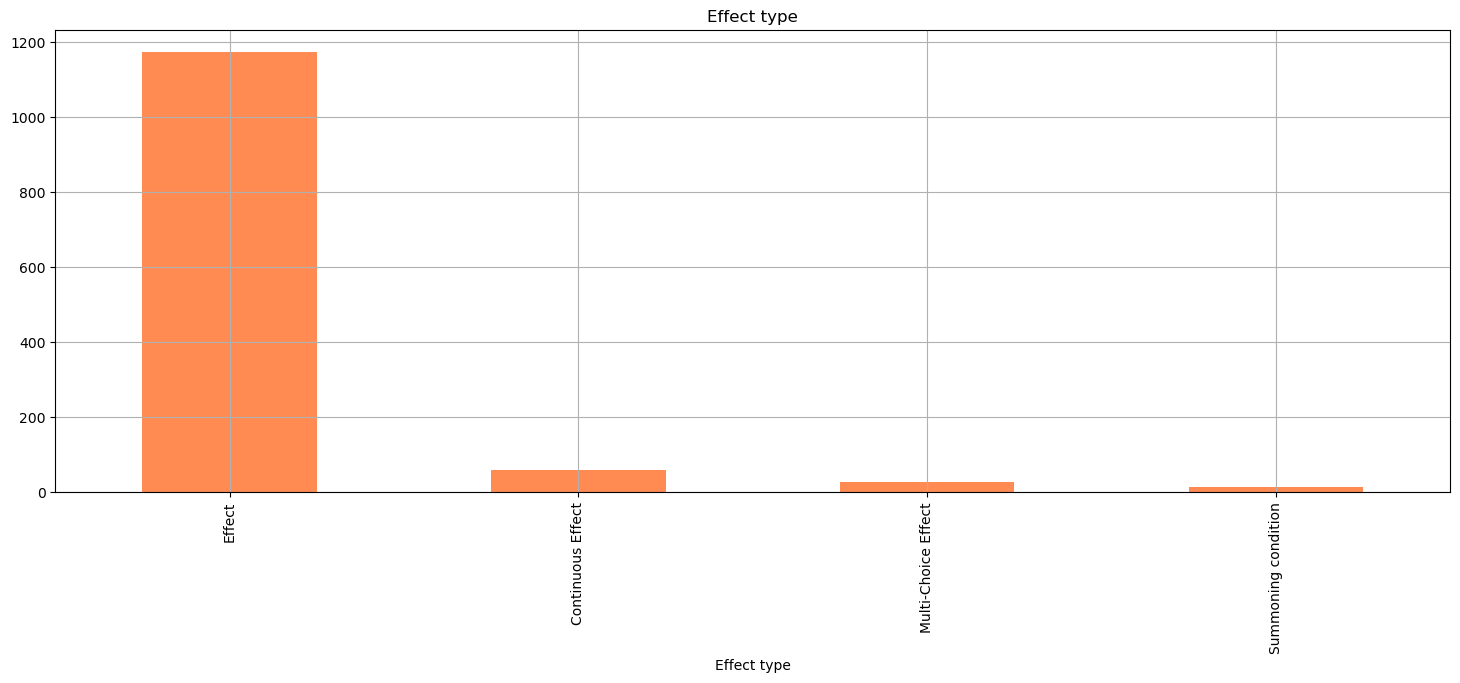

In [29]:
monster_effect_colors = colors_dict["Effect Monster"]
rush_df["Effect type"].explode("Effect type").value_counts().plot.bar(
    figsize=(18, 6), grid=True, color=monster_effect_colors, title="Effect type"
)
# plt.yscale('log')
plt.show()

### ATK

In [30]:
print("Total number of ATK values:", rush_df["ATK"].nunique())

Total number of ATK values:

38

In [31]:
rush_df.drop(columns=["Card type"]).groupby("ATK").nunique().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
)

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
ATK,,,,,,,,,,,,,,,,,
0,74,0,21,2,1,6,3,17,2,17,0,8,74,74,1,74,2
100,22,0,9,1,1,6,2,13,1,10,0,5,22,22,1,22,0
200,15,0,4,1,1,4,3,11,1,11,0,5,15,15,1,15,1
300,17,0,6,1,1,4,2,13,1,7,0,4,17,17,1,17,1
400,14,0,8,1,1,6,2,10,1,8,0,5,14,14,0,14,0
500,36,0,18,1,2,6,2,18,2,11,0,5,36,36,1,36,1
600,17,0,10,1,2,5,2,12,1,6,0,4,17,17,0,17,0
700,16,0,6,1,1,5,2,9,1,11,0,4,16,16,0,16,0
800,50,0,19,2,2,6,2,20,2,15,0,5,50,50,2,50,2


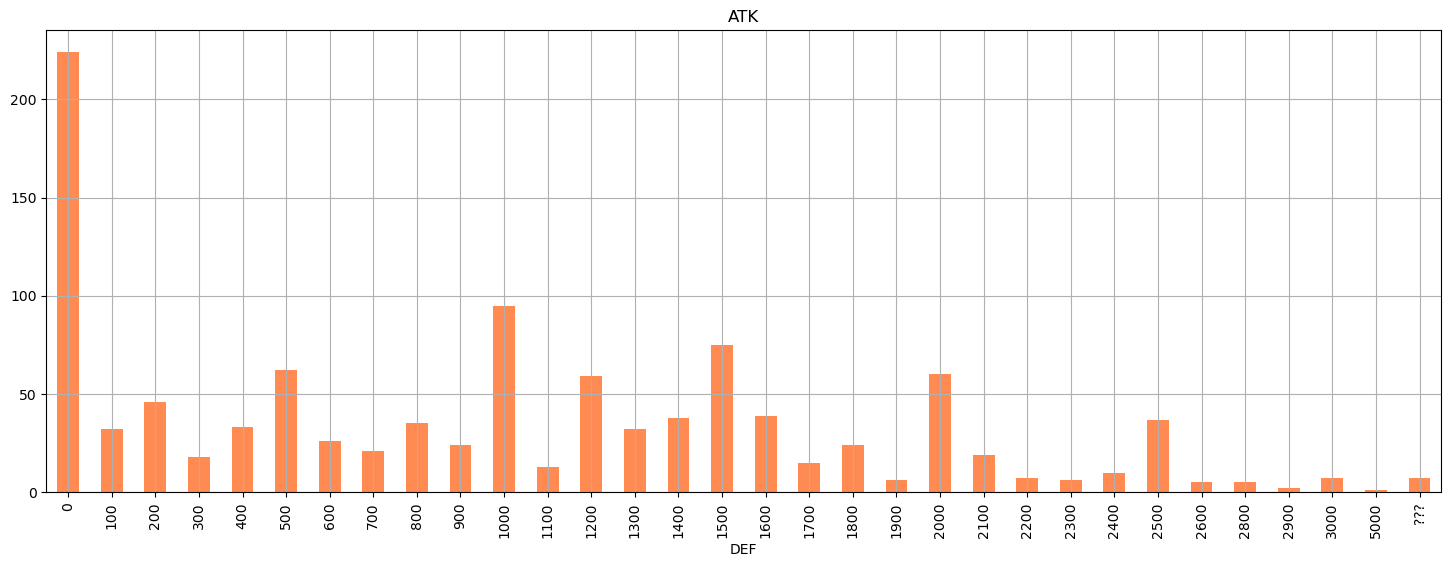

In [32]:
atk_colors = colors_dict["Monster Card"]
rush_df["DEF"].value_counts().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
).plot.bar(figsize=(18, 6), grid=True, color=atk_colors, title="ATK")
plt.show()

### DEF

In [33]:
print("Total number of DEF values:", rush_df["DEF"].nunique())

Total number of DEF values:

32

In [34]:
rush_df.drop(columns=["Card type"]).groupby("DEF").nunique().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
)

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
DEF,,,,,,,,,,,,,,,,,
0,224,0,33,2,2,6,3,24,4,27,5,10,224,224,3,224,2
100,32,0,11,1,1,5,2,11,1,17,0,7,32,32,1,32,1
200,46,0,11,2,1,6,3,14,1,21,0,8,46,46,2,46,2
300,18,0,7,1,1,6,2,12,1,7,0,4,18,18,0,18,0
400,33,0,12,1,1,6,2,13,1,14,0,7,33,33,0,33,0
500,62,0,17,1,1,6,2,19,2,16,0,8,62,62,1,62,2
600,26,0,9,2,1,6,2,14,2,16,0,7,26,26,0,26,3
700,21,0,3,1,1,6,2,12,1,13,0,5,21,21,0,21,2
800,35,0,13,2,1,6,2,18,2,15,0,6,35,35,2,35,1


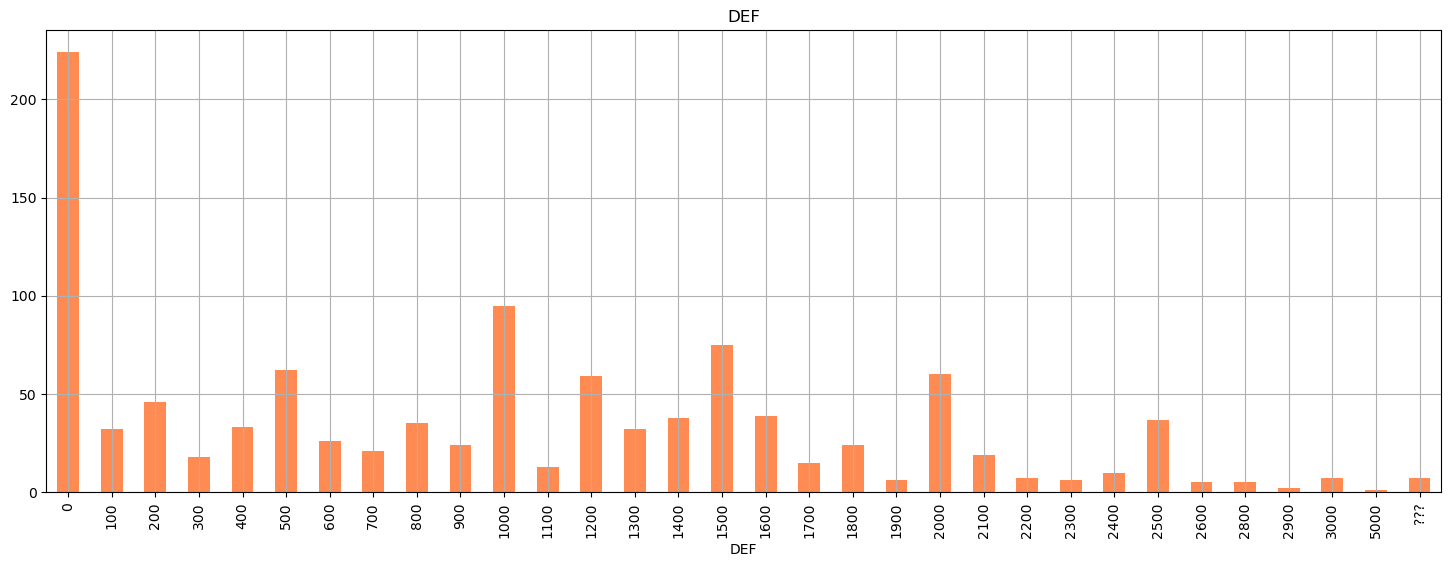

In [35]:
def_colors = colors_dict["Monster Card"]
rush_df["DEF"].value_counts().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
).plot.bar(figsize=(18, 6), grid=True, color=def_colors, title="DEF")
plt.show()

### Maximum mode

In [36]:
print("Total cards requiring maximum mode:", rush_df["Maximum mode"].sum())

Total cards requiring maximum mode:

53

In [37]:
rush_df[rush_df["Maximum mode"]]

,Name,Card type,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
7,Abyssal Dragon Lord Abyss Poseidra,Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Continuous Effect,)",0,2500,4000,10,Abyssal Dragon Lord Abyss Poseidra,https://yugipedia.com/wiki/Abyssal_Dragon_Lord...,NaN,2023-06-17 22:45:38,NaN
8,Abyssal Dragon Lord Abyss Poseidra [L],Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Effect,)",0,2300,NaN,10,Abyssal Dragon Lord Abyss Poseidra (L),https://yugipedia.com/wiki/Abyssal_Dragon_Lord...,NaN,2023-04-08 00:37:30,NaN
9,Abyssal Dragon Lord Abyss Poseidra [R],Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Continuous Effect,)",0,2400,NaN,10,Abyssal Dragon Lord Abyss Poseidra (R),https://yugipedia.com/wiki/Abyssal_Dragon_Lord...,NaN,2023-04-08 00:37:46,NaN
10,Abyssal Sea Dragon Abyss Kraken,Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Continuous Effect,)",0,2500,4000,10,Abyssal Sea Dragon Abyss Kraken,https://yugipedia.com/wiki/Abyssal_Sea_Dragon_...,NaN,2023-06-17 22:47:42,NaN
11,Abyssal Sea Dragon Abyss Kraken [L],Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Effect,)",0,2300,NaN,10,Abyssal Sea Dragon Abyss Kraken (L),https://yugipedia.com/wiki/Abyssal_Sea_Dragon_...,NaN,2023-04-08 00:37:51,NaN
12,Abyssal Sea Dragon Abyss Kraken [R],Monster Card,NaN,NaN,False,True,DARK,Effect Monster,Sea Serpent,"(Effect,)",0,2300,NaN,10,Abyssal Sea Dragon Abyss Kraken (R),https://yugipedia.com/wiki/Abyssal_Sea_Dragon_...,NaN,2023-05-31 06:54:48,NaN
13,Abysskite Prevent Wall,Trap Card,Normal Trap Card,NaN,False,True,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,Abysskite Prevent Wall,https://yugipedia.com/wiki/Abysskite_Prevent_Wall,NaN,2023-05-31 06:53:27,NaN
110,B.B.B. - Beast Brave Brandish,Spell Card,Normal Spell Card,NaN,False,True,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,B.B.B. - Beast Brave Brandish,https://yugipedia.com/wiki/B.B.B._-_Beast_Brav...,NaN,2023-06-02 06:37:13,NaN
173,Blaze Fiend Overlords Beelucitaroth,Monster Card,NaN,"(Blaze Fiend,)",False,True,FIRE,Effect Monster,Fiend,"(Continuous Effect, Summoning condition)",0,1200,3000,4,Blaze Fiend Overlords Beelucitaroth,https://yugipedia.com/wiki/Blaze_Fiend_Overlor...,NaN,2023-03-18 05:38:47,NaN
174,Blaze Fiend Overlords Beelucitaroth [L],Monster Card,NaN,"(Blaze Fiend,)",False,True,FIRE,Effect Monster,Fiend,"(Continuous Effect,)",0,1100,NaN,4,Blaze Fiend Overlords Beelucitaroth (L),https://yugipedia.com/wiki/Blaze_Fiend_Overlor...,NaN,2023-03-18 05:38:53,NaN


#### MAXIMUM ATK

In [38]:
print("Total number of MAXIMUM ATK values:", rush_df["MAXIMUM ATK"].nunique())

Total number of MAXIMUM ATK values:

5

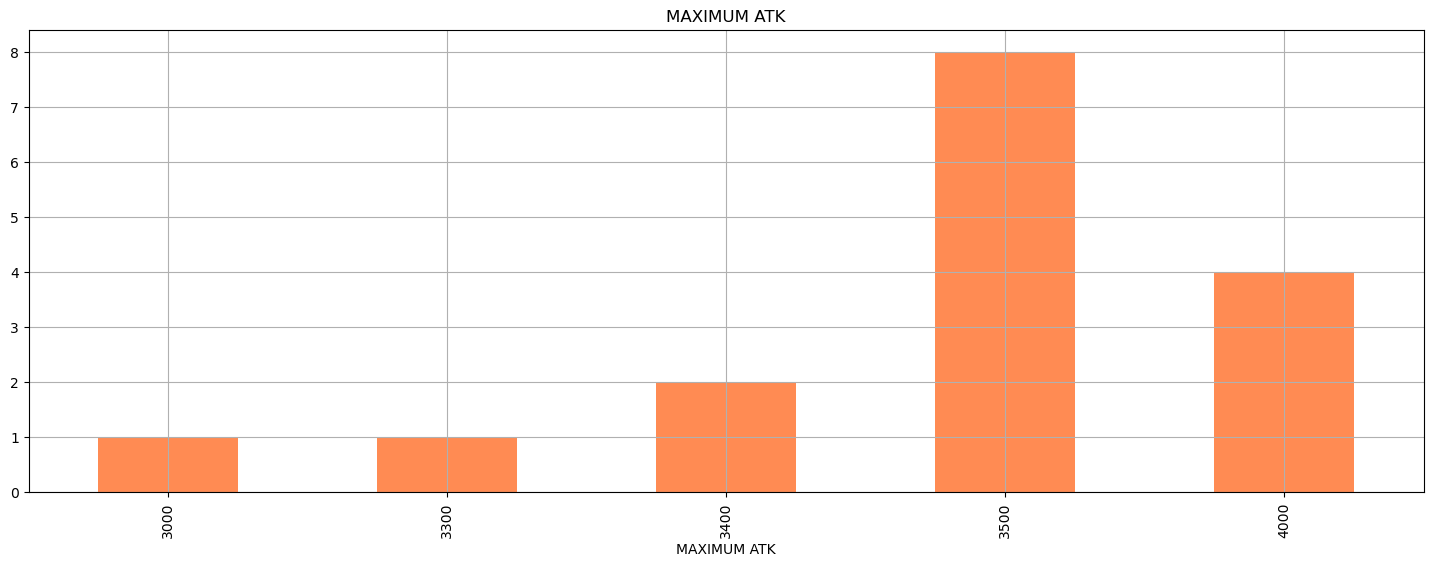

In [39]:
def_colors = colors_dict["Monster Card"]
rush_df["MAXIMUM ATK"].value_counts().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
).plot.bar(figsize=(18, 6), grid=True, color=def_colors, title="MAXIMUM ATK")
plt.show()

##### By ATK

In [40]:
max_atk_crosstab = pd.crosstab(rush_df["ATK"], rush_df["MAXIMUM ATK"])
max_atk_crosstab

MAXIMUM ATK,3000,3300,3400,3500,4000
ATK,,,,,
1200,1,0,0,0,0
1500,0,1,0,0,0
1900,0,0,1,4,0
2000,0,0,0,1,1
2100,0,0,1,0,0
2400,0,0,0,1,0
2500,0,0,0,2,3


##### By DEF

In [41]:
max_def_crosstab = pd.crosstab(rush_df["DEF"], rush_df["MAXIMUM ATK"])
max_def_crosstab

MAXIMUM ATK,3000,3300,3400,3500,4000
DEF,,,,,
0,1,1,2,8,4


### Level/Rank

In [42]:
rush_df.drop(columns=["Card type"]).groupby("Level/Rank").nunique().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
)

,Name,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Page name,Page URL,Artwork,Modification date,Errata
Level/Rank,,,,,,,,,,,,,,,,,
1,95,0,29,1,1,6,2,21,2,11,11,0,95,95,2,95,2
2,76,0,30,1,1,6,3,21,1,17,11,0,76,76,1,76,1
3,164,0,32,1,2,6,2,23,2,16,14,0,164,164,1,164,4
4,246,0,43,2,2,6,3,22,3,19,20,1,246,246,2,246,4
5,66,0,22,2,2,6,3,18,3,18,17,1,66,66,2,66,3
6,90,0,21,2,1,6,3,21,2,21,15,0,90,90,3,90,3
7,171,0,43,2,2,6,3,25,3,24,15,0,171,171,3,171,4
8,83,0,24,2,1,6,3,19,3,19,12,0,83,83,2,83,4
9,57,0,28,1,1,6,1,17,3,14,12,0,57,57,2,57,0


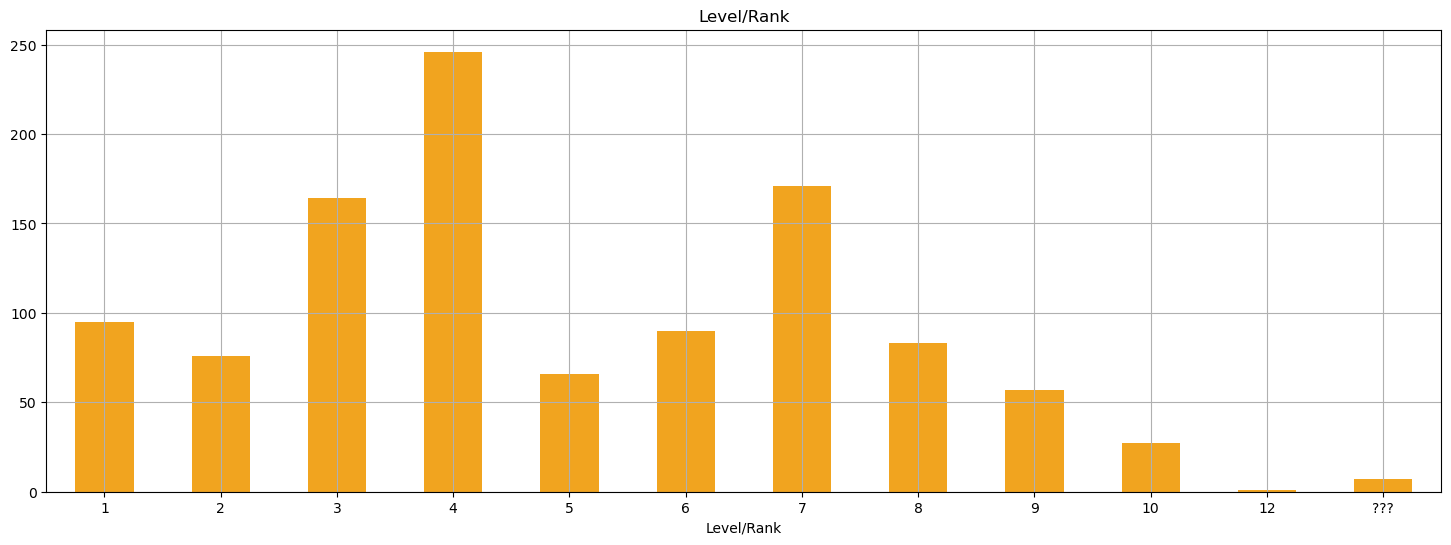

In [43]:
stars_colors = colors_dict["Level"]
rush_df["Level/Rank"].value_counts().sort_index(
    key=lambda x: pd.to_numeric(x, errors="coerce")
).plot.bar(figsize=(18, 6), grid=True, rot=0, color=stars_colors, title="Level/Rank")
plt.show()

#### ATK statistics

In [44]:
rush_df[["Level/Rank", "ATK"]].apply(pd.to_numeric, errors="coerce").dropna().astype(
    int
).groupby("Level/Rank").describe()

ATK                                                            
            count         mean         std     min     25%     50%     75%   
Level/Rank                                                                   
1            95.0   216.842105  282.335485     0.0     0.0   100.0   400.0  \
2            76.0   582.894737  308.280460     0.0   400.0   550.0   800.0   
3           164.0   906.097561  333.174934     0.0   800.0  1000.0  1200.0   
4           246.0  1239.430894  328.183127     0.0  1100.0  1300.0  1500.0   
5            66.0  1533.333333  478.244654     0.0  1500.0  1600.0  1700.0   
6            90.0  1667.777778  504.101777     0.0  1600.0  1700.0  1800.0   
7           171.0  2195.906433  578.777284     0.0  2200.0  2400.0  2500.0   
8            83.0  2401.204819  522.539292     0.0  2400.0  2500.0  2500.0   
9            57.0  2892.982456  216.184155  2200.0  2800.0  2900.0  3000.0   
10           27.0  2314.814815  489.665273  1500.0  2000.0  2300.0  2500.0   
12            1.0  5000.000000         NaN  5000.0  5000.0  5000.0  5000.0   

                    
               max  
Level/Rank          
1           1000.0  
2           2000.0  
3           1300.0  
4           2000.0  
5           2500.0  
6           2500.0  
7           2700.0  
8           3500.0  
9           3500.0  
10          4000.0  
12          5000.0

#### DEF statistics

In [45]:
rush_df[["Level/Rank", "DEF"]].apply(pd.to_numeric, errors="coerce").dropna().astype(
    int
).groupby("Level/Rank").describe()

DEF                                                            
            count         mean         std     min     25%     50%     75%   
Level/Rank                                                                   
1            95.0   534.736842  568.081583     0.0     0.0   200.0  1000.0  \
2            76.0   632.894737  434.323430     0.0   300.0   600.0   900.0   
3           164.0   589.634146  473.807046     0.0     0.0   600.0  1000.0   
4           246.0   638.211382  549.213958     0.0     0.0   600.0  1200.0   
5            66.0   963.636364  661.847383     0.0   425.0  1000.0  1500.0   
6            90.0   951.111111  680.588715     0.0   500.0   900.0  1500.0   
7           171.0  1501.169591  722.820318     0.0  1300.0  1500.0  2000.0   
8            83.0  1714.457831  720.455908     0.0  1500.0  2000.0  2000.0   
9            57.0  2161.403509  679.483624     0.0  2000.0  2400.0  2500.0   
10           27.0   266.666667  779.052679     0.0     0.0     0.0     0.0   
12            1.0  5000.000000         NaN  5000.0  5000.0  5000.0  5000.0   

                    
               max  
Level/Rank          
1           1500.0  
2           2000.0  
3           1500.0  
4           2000.0  
5           3000.0  
6           2200.0  
7           2800.0  
8           3000.0  
9           3000.0  
10          2800.0  
12          5000.0

## Spell & Trap

### Properties

In [46]:
print("Total number of properties:", rush_df["Property"].nunique())

Total number of properties:

5

In [47]:
rush_df.drop(columns=["Card type"]).groupby("Property").nunique()

,Name,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Property,,,,,,,,,,,,,,,,,
???,3,1,1,1,0,0,0,1,0,0,0,0,3,3,0,3,0
Equip Spell Card,28,9,1,1,0,0,0,1,0,0,0,0,28,28,1,28,2
Field Spell Card,32,11,1,1,0,0,0,1,0,0,0,0,32,32,1,32,2
Normal Spell Card,244,44,2,2,0,0,0,1,0,0,0,0,244,244,2,244,4
Normal Trap Card,211,38,2,2,0,0,0,1,0,0,0,0,211,211,2,211,2


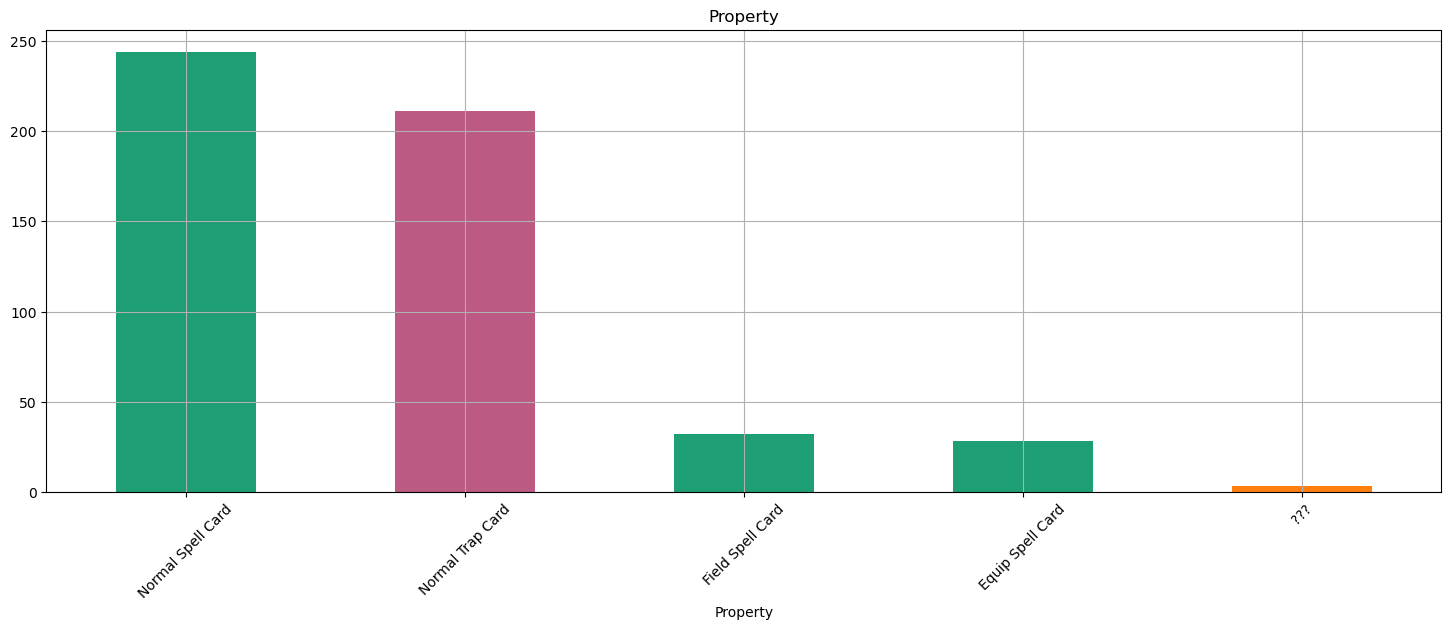

In [48]:
st_colors = [
    colors_dict[i]
    for i in rush_df[["Card type", "Property"]].value_counts().index.get_level_values(0)
]
rush_df["Property"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=45, color=st_colors, title="Property"
)
plt.show()

## Archseries

In [49]:
exploded_archseries = rush_df.explode("Archseries")
print("Total number of Archseries:", exploded_archseries["Archseries"].nunique())

Total number of Archseries:

70

In [50]:
exploded_archseries.groupby("Archseries").nunique()

,Name,Card type,Property,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
Archseries,,,,,,,,,,,,,,,,,,
Arts Angel,5,1,0,1,1,1,2,1,1,4,4,0,4,5,5,0,5,0
Band Group,7,2,1,1,1,1,2,1,1,1,5,0,3,7,7,0,7,0
Baseball,14,3,3,1,1,1,2,2,1,3,7,0,2,14,14,0,14,0
Beast Gear,11,3,2,1,1,4,2,1,1,8,9,0,5,11,11,0,11,0
Blaze Fiend,13,3,2,1,2,1,1,1,4,2,7,2,2,13,13,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ultimate Flag,8,1,0,1,1,1,2,1,1,2,6,0,5,8,8,0,8,0
Umi (series),2,1,1,1,1,0,0,0,1,0,0,0,0,2,2,0,2,1
Voidvelgr,22,2,1,1,1,1,3,1,1,12,11,0,8,22,22,1,22,0


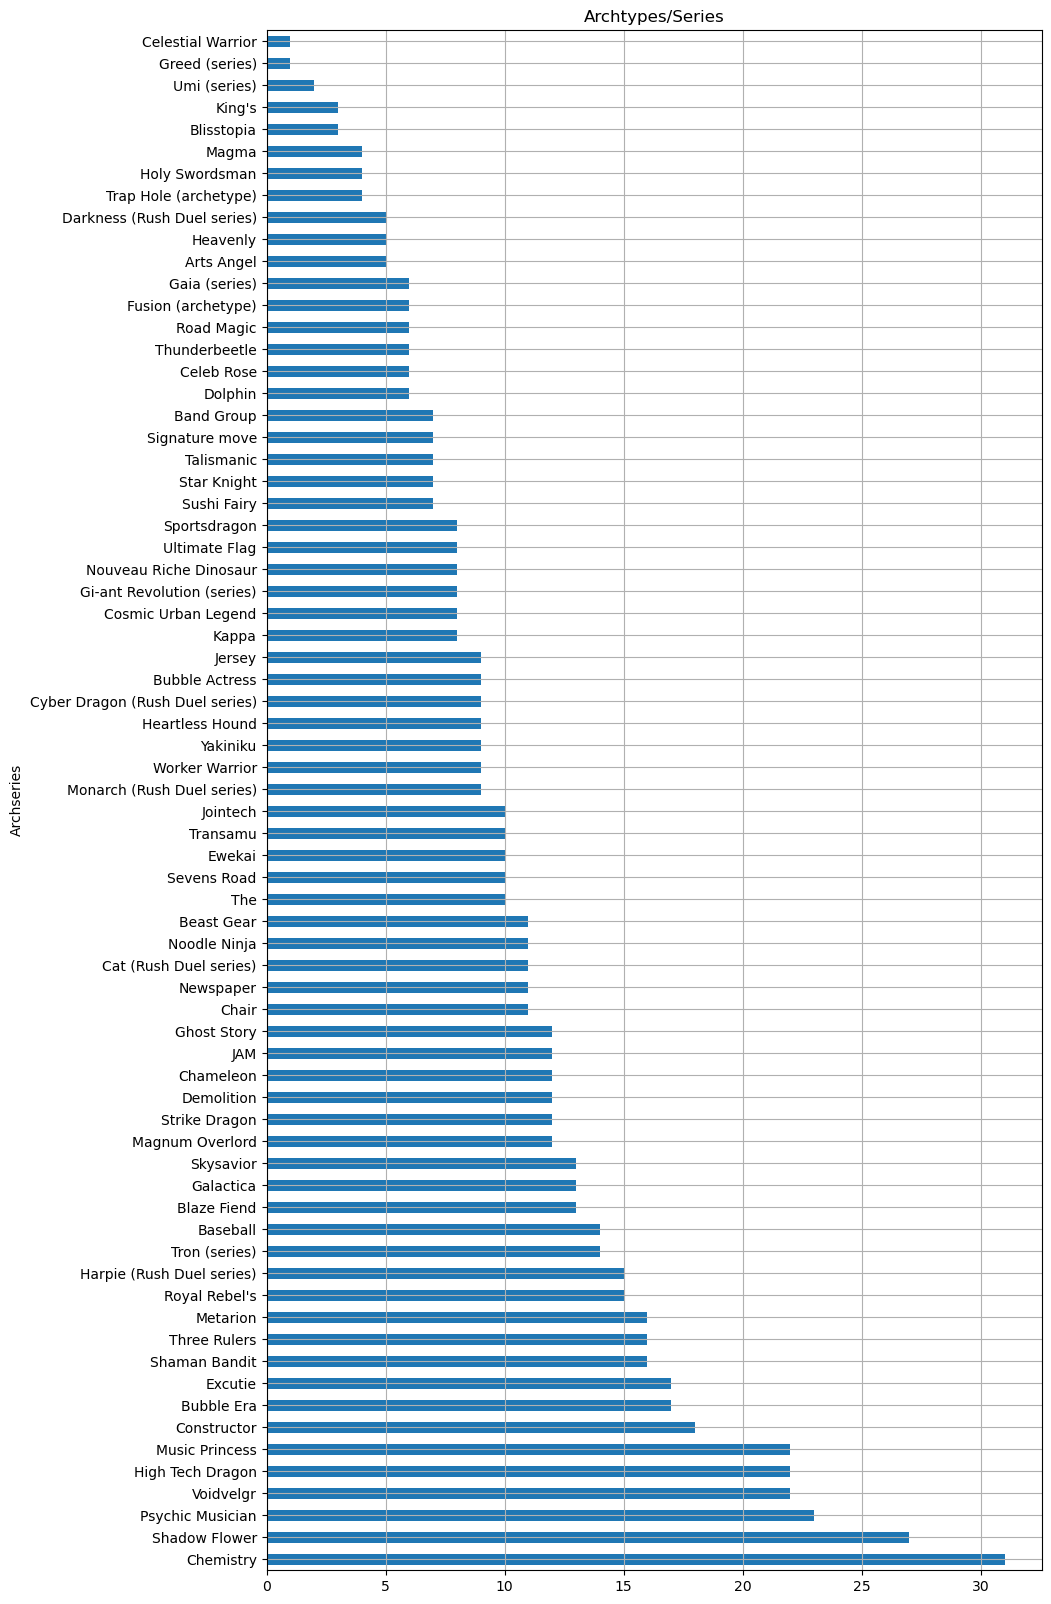

In [51]:
exploded_archseries["Archseries"].value_counts().plot.barh(
    figsize=(10, 20), grid=True, title="Archtypes/Series"
)
plt.show()

### By card type

In [52]:
archseries_crosstab = pd.crosstab(
    exploded_archseries["Archseries"], exploded_archseries["Card type"], margins=True
)
archseries_crosstab

Card type,???,Monster Card,Spell Card,Trap Card,All
Archseries,,,,,
Arts Angel,0,5,0,0,5
Band Group,0,5,2,0,7
Baseball,0,8,4,2,14
Beast Gear,0,9,1,1,11
Blaze Fiend,0,8,3,2,13
...,...,...,...,...,...
Umi (series),0,0,2,0,2
Voidvelgr,0,18,4,0,22
Worker Warrior,0,6,1,2,9


### By primary type

In [53]:
archseries_crosstab_b = pd.crosstab(
    exploded_archseries["Archseries"], exploded_archseries["Primary type"], margins=True
)
archseries_crosstab_b

Primary type,Effect Monster,Fusion Monster,Normal Monster,All
Archseries,,,,
Arts Angel,2,0,3,5
Band Group,4,0,1,5
Baseball,5,0,3,8
Beast Gear,6,0,3,9
Blaze Fiend,8,0,0,8
...,...,...,...,...
Ultimate Flag,6,0,2,8
Voidvelgr,11,4,3,18
Worker Warrior,3,1,2,6


### By monster type

In [54]:
archseries_crosstab_d = pd.crosstab(
    exploded_archseries["Archseries"], exploded_archseries["Monster type"], margins=True
)
archseries_crosstab_d

Monster type,Aqua,Beast,Beast-Warrior,Celestial Warrior,Cyberse,Cyborg,Dinosaur,Dragon,Fairy,Fiend,Galaxy (Type),High Dragon,Insect,Machine,Magical Knight,Omega Psychic,Plant,Psychic,Pyro,Reptile,Sea Serpent,Spellcaster,Thunder,Warrior,Winged Beast,Wyrm,Zombie,All
Archseries,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arts Angel,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
Band Group,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,5
Baseball,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,8
Beast Gear,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
Blaze Fiend,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ultimate Flag,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,8
Voidvelgr,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18
Worker Warrior,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6


### By property

In [55]:
archseries_crosstab_e = pd.crosstab(
    exploded_archseries["Archseries"], exploded_archseries["Property"], margins=True
)
archseries_crosstab_e

Property,???,Equip Spell Card,Field Spell Card,Normal Spell Card,Normal Trap Card,All
Archseries,,,,,,
Band Group,0,0,0,2,0,2
Baseball,0,0,1,3,2,6
Beast Gear,0,0,1,0,1,2
Blaze Fiend,0,0,0,3,2,5
Blisstopia,0,0,3,0,0,3
Bubble Actress,0,0,2,1,0,3
Bubble Era,0,0,1,4,3,8
Chair,0,0,0,1,2,3
Chameleon,0,0,0,2,1,3


## Legend

In [56]:
print("Total number of Legend cards", rush_df["Legend"].sum())

Total number of Legend cards

57

In [57]:
rush_df[rush_df["Legend"]]

,Name,Card type,Property,Archseries,Legend,Maximum mode,Attribute,Primary type,Monster type,Effect type,DEF,ATK,MAXIMUM ATK,Level/Rank,Page name,Page URL,Artwork,Modification date,Errata
6,Abyss Soldier,Monster Card,NaN,NaN,True,False,WATER,Effect Monster,Aqua,"(Effect,)",1300,1800,NaN,4,Abyss Soldier (Rush Duel),https://yugipedia.com/wiki/Abyss_Soldier_(Rush...,NaN,2023-03-17 23:43:42,"(Any,)"
37,Alien Shocktrooper,Monster Card,NaN,NaN,True,False,EARTH,Normal Monster,Reptile,NaN,800,1900,NaN,4,Alien Shocktrooper (Rush Duel),https://yugipedia.com/wiki/Alien_Shocktrooper_...,NaN,2023-03-18 00:13:59,NaN
79,Archfiend Soldier,Monster Card,NaN,NaN,True,False,DARK,Normal Monster,Fiend,NaN,1500,1900,NaN,4,Archfiend Soldier (Rush Duel),https://yugipedia.com/wiki/Archfiend_Soldier_(...,NaN,2023-03-18 02:15:12,"(Type,)"
120,Barrel Dragon,Monster Card,NaN,NaN,True,False,DARK,Effect Monster,Machine,"(Effect,)",2200,2600,NaN,7,Barrel Dragon (Rush Duel),https://yugipedia.com/wiki/Barrel_Dragon_(Rush...,"(Edited,)",2023-03-18 03:53:43,"(Any,)"
145,Behemoth the King of All Animals,Monster Card,NaN,NaN,True,False,EARTH,Effect Monster,Beast,"(Effect,)",1500,2700,NaN,7,Behemoth the King of All Animals (Rush Duel),https://yugipedia.com/wiki/Behemoth_the_King_o...,NaN,2023-03-18 04:40:32,"(Any,)"
189,Blue-Eyes White Dragon,Monster Card,NaN,NaN,True,False,LIGHT,Normal Monster,Dragon,NaN,2500,3000,NaN,8,Blue-Eyes White Dragon (Rush Duel),https://yugipedia.com/wiki/Blue-Eyes_White_Dra...,"(Alternate,)",2023-03-18 05:57:53,"(Name, Type)"
217,Buster Blader,Monster Card,NaN,NaN,True,False,EARTH,Effect Monster,Warrior,"(Continuous Effect,)",2300,2600,NaN,7,Buster Blader (Rush Duel),https://yugipedia.com/wiki/Buster_Blader_(Rush...,"(Edited,)",2023-04-01 13:06:09,"(Type,)"
230,Card Destruction,Spell Card,Normal Spell Card,NaN,True,False,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,NaN,Card Destruction (Rush Duel),https://yugipedia.com/wiki/Card_Destruction_(R...,NaN,2023-03-18 07:25:04,"(Type,)"
322,The Creator,Monster Card,NaN,NaN,True,False,LIGHT,Effect Monster,Thunder,"(Effect,)",3000,2300,NaN,8,The Creator (Rush Duel),https://yugipedia.com/wiki/The_Creator_(Rush_D...,NaN,2023-03-20 13:37:06,"(Any,)"
352,Cyber-Tech Alligator,Monster Card,NaN,NaN,True,False,WIND,Normal Monster,Machine,NaN,1600,2500,NaN,5,Cyber-Tech Alligator (Rush Duel),https://yugipedia.com/wiki/Cyber-Tech_Alligato...,NaN,2023-03-18 10:19:34,NaN


#### By card type

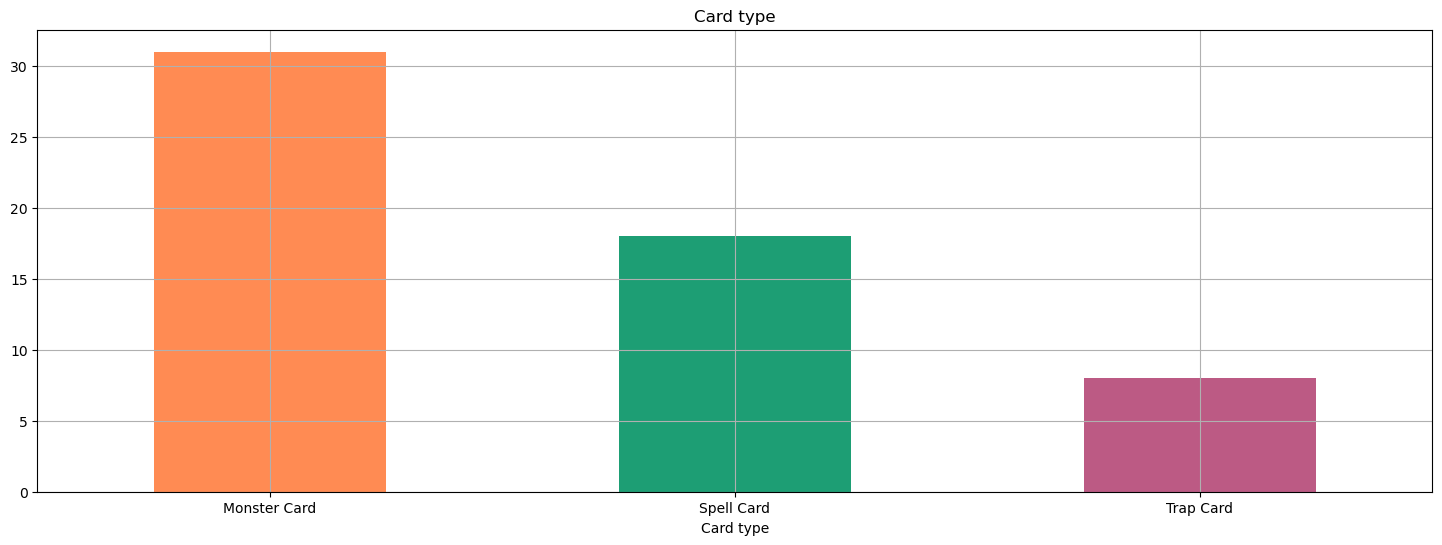

In [58]:
card_type_colors = [
    colors_dict[i] for i in rush_df[rush_df["Legend"]]["Card type"].value_counts().index
]
rush_df[rush_df["Legend"]]["Card type"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=card_type_colors, title="Card type"
)
plt.show()

#### By Attribute

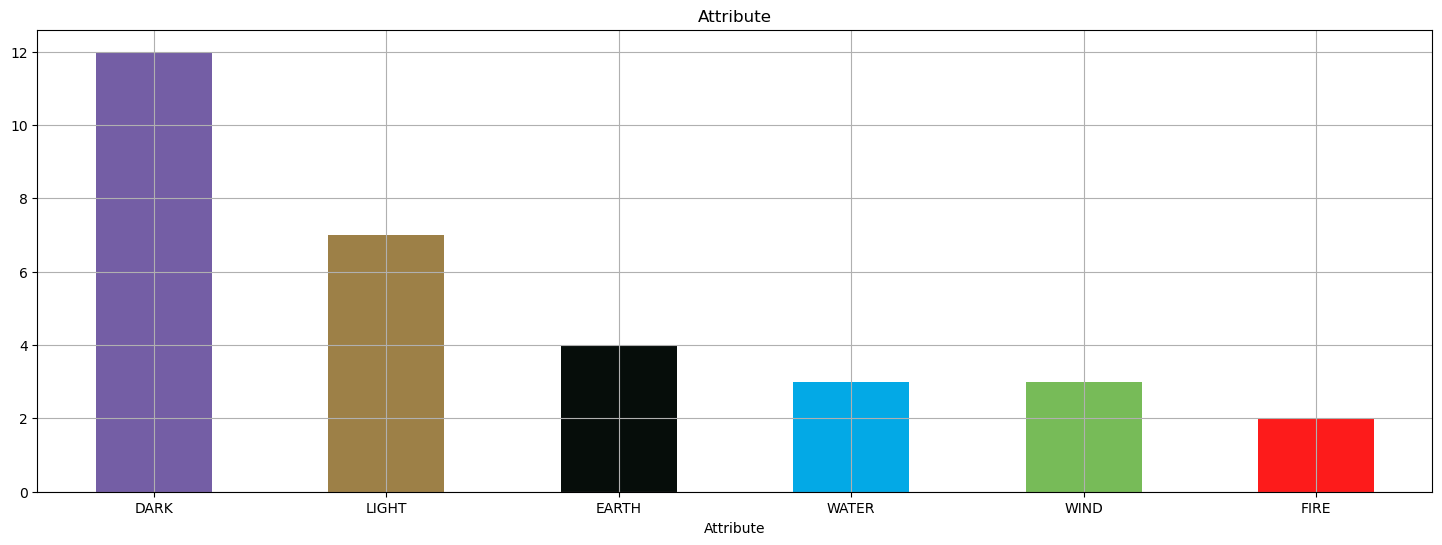

In [59]:
attribute_colors = [
    colors_dict[i] for i in rush_df[rush_df["Legend"]]["Attribute"].value_counts().index
]
rush_df[rush_df["Legend"]]["Attribute"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=attribute_colors, title="Attribute"
)
plt.show()

#### By primary type

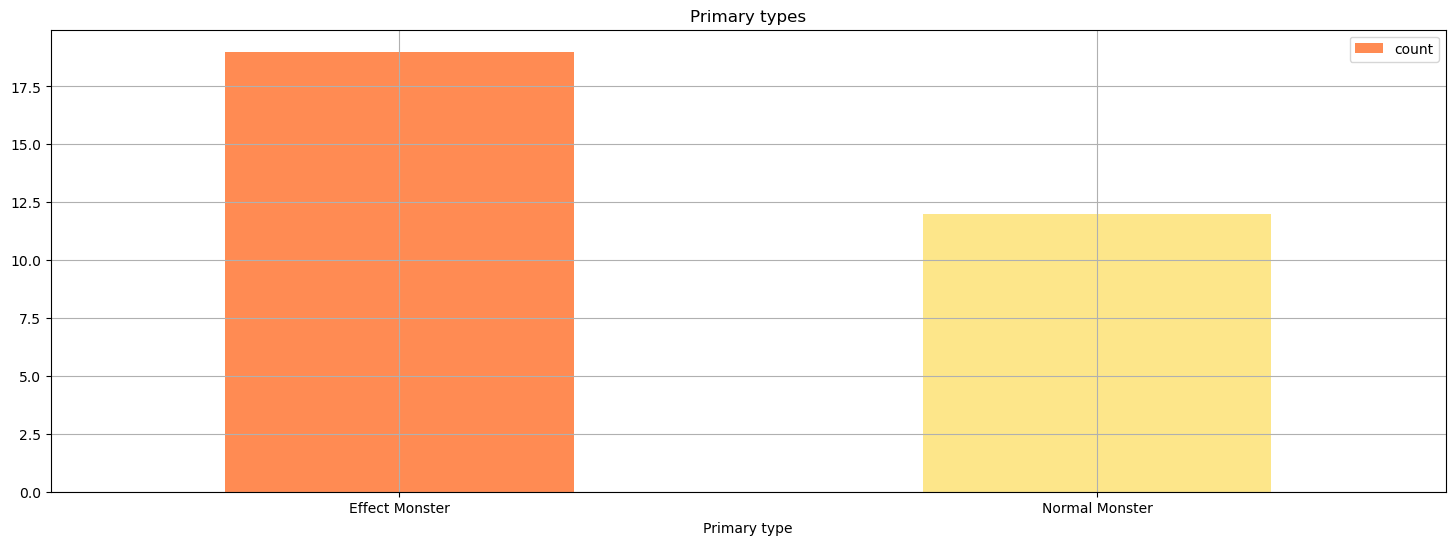

In [60]:
monster_type_colors = [
    colors_dict[i]
    for i in rush_df[rush_df["Legend"]]["Primary type"].value_counts().index
]
rush_df[rush_df["Legend"]]["Primary type"].value_counts().plot.bar(
    figsize=(18, 6),
    stacked=True,
    grid=True,
    rot=0,
    legend=True,
    color=monster_type_colors,
    title="Primary types",
)
# plt.yscale('log')
plt.show()

#### By monster type

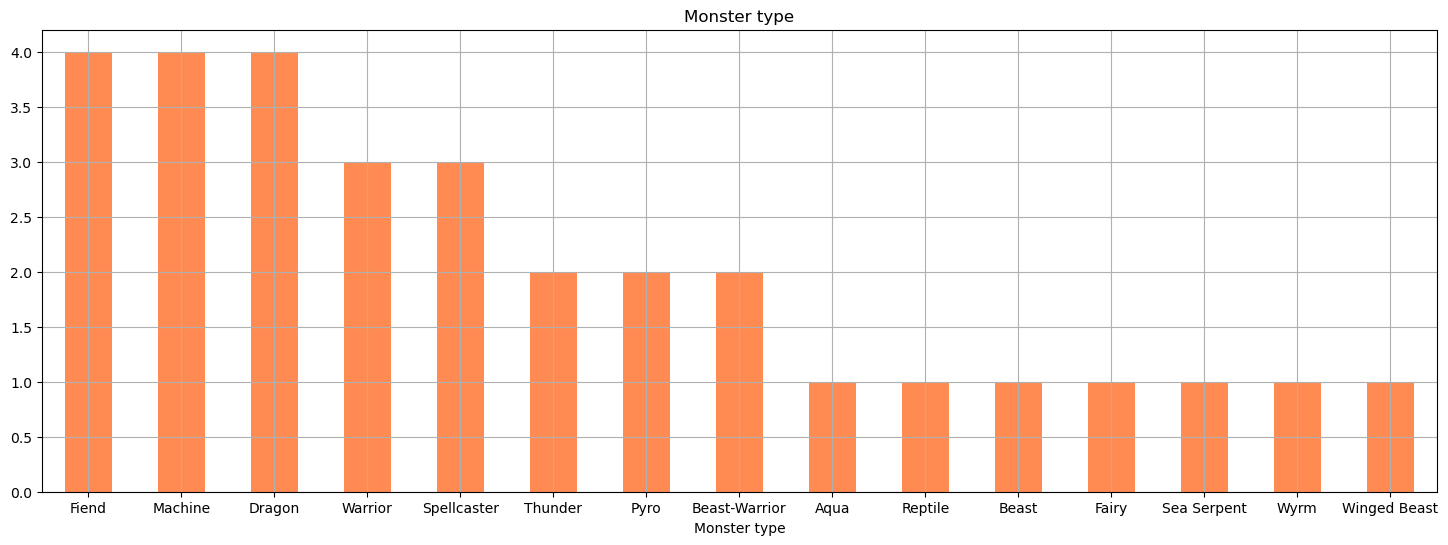

In [61]:
monster_type_colors = colors_dict["Monster Card"]
rush_df[rush_df["Legend"]]["Monster type"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=monster_type_colors, title="Monster type"
)
plt.show()

## Artworks

In [62]:
print(
    "Total number of cards with edited or alternate artworks:",
    rush_df["Artwork"].count(),
)

Total number of cards with edited or alternate artworks:

58

In [63]:
rush_df[["Name", "Artwork"]].dropna()

,Name,Artwork
118,Bandijo of the Battle Ballad,"(Edited,)"
120,Barrel Dragon,"(Edited,)"
185,Blue Tooth Burst Dragon,"(Alternate,)"
189,Blue-Eyes White Dragon,"(Alternate,)"
206,Bubble Kingdom,"(Edited,)"
217,Buster Blader,"(Edited,)"
223,CAN:D,"(Alternate,)"
225,CAN:D LIVE,"(Alternate,)"
234,Cat Claw Girl,"(Alternate,)"
254,Chemicalize Salamander,"(Alternate,)"


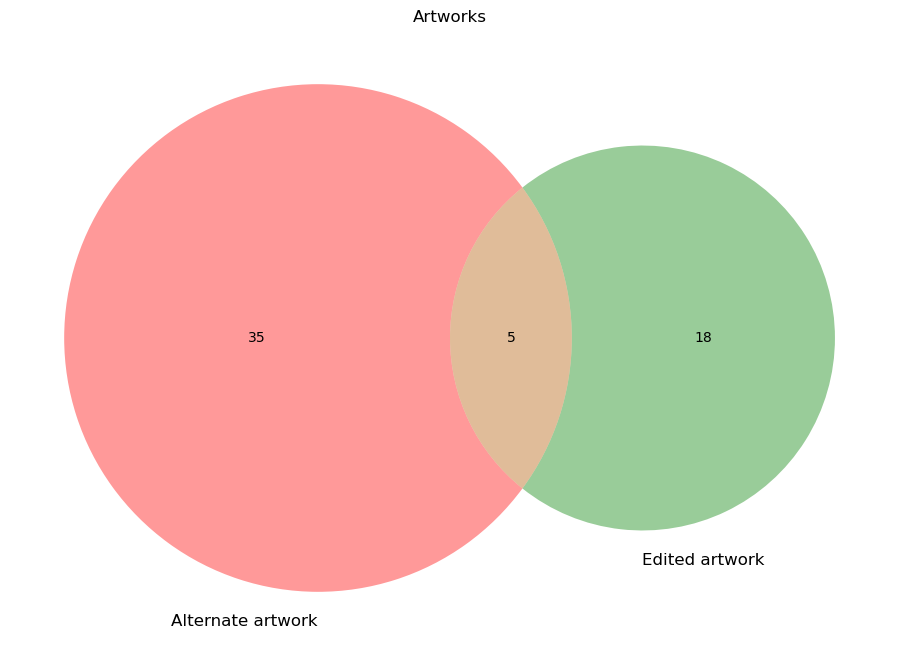

In [64]:
artwork_value_counts = rush_df["Artwork"].value_counts()
plt.figure(figsize=(20, 8))
plt.title("Artworks")
venn2(
    subsets=(
        artwork_value_counts[("Alternate",)],
        artwork_value_counts[("Edited",)],
        artwork_value_counts[("Alternate", "Edited")],
    ),
    set_labels=("Alternate artwork", "Edited artwork"),
)
plt.show()

### By card type

In [65]:
artwork_crosstab = pd.crosstab(rush_df["Artwork"], rush_df["Card type"])
artwork_crosstab

Card type,Monster Card,Spell Card,Trap Card
Artwork,,,
"(Alternate,)",28,5,2
"(Alternate, Edited)",5,0,0
"(Edited,)",13,4,1


### By primary type

In [66]:
artwork_crosstab_b = pd.crosstab(rush_df["Artwork"], rush_df["Primary type"])
artwork_crosstab_b

Primary type,Effect Monster,Fusion Monster,Normal Monster
Artwork,,,
"(Alternate,)",19,1,8
"(Alternate, Edited)",5,0,0
"(Edited,)",7,2,4


More granularity is unnecessary

## Errata

In [67]:
print("Total number of cards with errata:", rush_df["Errata"].count())

Total number of cards with errata:

162

In [68]:
rush_df[["Name", "Errata"]].dropna()

,Name,Errata
3,Abare Ushioni,"(Any,)"
6,Abyss Soldier,"(Any,)"
40,Alligator's Sword,"(Type,)"
41,Alligator's Sword Dragon,"(Any,)"
60,Ancient Rules,"(Any,)"
...,...,...
1543,The Warrior Returning Alive,"(Type,)"
1545,Wasteland,"(Type,)"
1556,Widespread Ruin,"(Name,)"
1580,Yami,"(Type,)"


### By card type

In [69]:
errata_crosstab = pd.crosstab(rush_df["Errata"], rush_df["Card type"])
errata_crosstab

Card type,Monster Card,Spell Card,Trap Card
Errata,,,
"(Any,)",33,20,16
"(Name,)",12,2,2
"(Name, Type)",10,1,0
"(Type,)",37,29,0


### By primary type

In [70]:
errata_crosstab_b = pd.crosstab(rush_df["Errata"], rush_df["Primary type"])
errata_crosstab_b

Primary type,Effect Monster,Fusion Monster,Normal Monster
Errata,,,
"(Any,)",26,2,5
"(Name,)",5,2,5
"(Name, Type)",0,2,8
"(Type,)",10,2,25


### By artwork

In [71]:
errata_crosstab_c = pd.crosstab(rush_df["Artwork"], rush_df["Errata"])
errata_crosstab_c

Errata,"(Any,)","(Name,)","(Name, Type)","(Type,)"
Artwork,,,,
"(Alternate,)",1,1,3,2
"(Alternate, Edited)",1,0,0,1
"(Edited,)",2,0,0,1


More granularity is unnecessary

# Epilogue

In [72]:
benchmark("rush", timestamp)

In [73]:
footer(timestamp)

<div align='right'>
    Execution completed 26/06/2023 04:07 UTC
</div>

## HTML export

In [74]:
# Save notebook on disck before generating HTML report
save_notebook()

Notebook saved to disk

In [75]:
! jupyter nbconvert Rush.ipynb --output-dir='../' --to=HTML --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='exclude' --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook Rush.ipynb to HTML


[NbConvertApp] Writing 1794008 bytes to ../Rush.html


## Git

In [ ]:
! git add "../*[Rr]ush*"

In [ ]:
! git commit -m {"'Rush duel update-" + timestamp.isoformat() + "'"}